# Import Modules

In [ ]:
import time
from zipfile import ZipFile
import json
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
plt.style.use('dark_background')

Found GPU at: /device:GPU:0


# Functions Definition

## Datasets Tools

In [ ]:
def print_dataset_info(name, x_train, y_train, x_test, y_test):
    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    print(f'{name} dataset information:')
    print(f'  * Total Train Samples: {train_samples}')
    print(f'  * Total Test Samples:  {test_samples}')
    print(f'  * Input Shape:  {x_train.shape[1:]}')
    print(f'  * Output Shape: {y_train.shape[1:]}')
    print(f'Shapes Detail:')
    print(f'  * x_train:  {x_train.shape}')
    print(f'  * y_train:  {y_train.shape}')
    print(f'  * x_test:   {x_test.shape}')
    print(f'  * y_test:   {y_test.shape}')


def show_random_image(name, x_train, y_train, x_test, y_test):
    train_samples = x_train.shape[0]
    test_samples = x_test.shape[0]
    if x_train.ndim == 4 and x_train.shape[-1] not in (3, 4):
        print(f'Invalid image shape {x_train.shape[1:]} for image data')
        x_train = x_train.reshape(x_train.shape[:-1])
        x_test = x_test.reshape(x_test.shape[:-1])
        print(f'Images reshaped to: {x_train.shape[1:]}')
    print('Random Train Example: ')
    index = np.random.randint(0, train_samples)
    plt.imshow(x_train[index, ])
    plt.show()
    print(f'Label: {y_train[index,]}')
    print('Random Test Example: ')
    index = np.random.randint(0, test_samples)
    plt.imshow(x_test[index, ])
    plt.show()
    print(f'Label: {y_test[index,]}')


def print_cifar10_classes():
    num_classes = 10
    classes = {
        0: 'airplane',
        1: 'automobile',
        2: 'bird',
        3: 'cat',
        4: 'deer',
        5: 'dog',
        6: 'frog',
        7: 'horse',
        8: 'ship',
        9: 'truck'
    }
    print('CIFAR10 Classes:')
    for i in range(num_classes):
        print(f'  {i}- {classes[i]}')


## Train Tools

In [ ]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


def save_run_info(model, history, optimizer, dataset: str, comment=None):
    # Load Data
    model_name = model.name
    optimizer_name = optimizer.get_config()['name']
    model_config = model.to_json()
    history_dict = {}
    epochs = len(history.history['loss'])
    history_dict['epochs'] = list(range(1, epochs+1))
    history_dict.update(history.history)
    optimizer_config = optimizer.get_config()
    for i in optimizer_config:
        if type(optimizer_config[i]) not in (str, float) :
            optimizer_config[i] = round(float(optimizer_config[i]), 4)
    # Serializing
    max_acc = round(max(history_dict['accuracy']), 2)
    max_val_acc = round(max(history_dict['val_accuracy']), 2)
    acc_str = f'{max_val_acc:.2f}{max_acc:.2f}'.replace('.', '')
    time_str = time.strftime("%Y%m%d_%H%M%S")
    zipfile_name = f'{dataset}_{model_name}_{acc_str}_{optimizer_name}_{time_str}.zip'
    history_df = pd.DataFrame(history_dict)
    with ZipFile(zipfile_name, mode='w') as zip_file:
        zip_file.writestr(f'history.csv', history_df.to_csv(index=False))
        zip_file.writestr(f'dataset.txt', dataset)
        zip_file.writestr(f'model_config.json',
                          json.dumps(model_config, indent=4))
        zip_file.writestr(f'optimizer_config.json',
                          json.dumps(optimizer_config, indent=4))
        if comment:
            zip_file.writestr('comment.txt', comment)
    print('save_run_info completed')


# Optimizers Classes

In [ ]:
class Gravity(tf.keras.optimizers.Optimizer):
    def __init__(self, learning_rate=0.1, alpha=0.01, beta=0.9, name="Gravity", **kwargs):
        super(Gravity, self).__init__(name, **kwargs)
        self._set_hyper('learning_rate', kwargs.get('lr', learning_rate))
        self._set_hyper('decay', self._initial_decay)
        self._set_hyper('alpha', alpha)
        self._set_hyper('beta', beta)
        self.epsilon = 1e-7
    def _create_slots(self, var_list):
        alpha = self._get_hyper("alpha")
        stddev = alpha/self.learning_rate
        initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=stddev, seed=None)
        # initializer = 'zeros'
        for var in var_list:
            self.add_slot(var, "velocity", initializer=initializer)

    @tf.function
    def _resource_apply_dense(self, grad, var):
        # Get Data
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype) # handle learning rate decay
        beta_hat = self._get_hyper("beta", var_dtype)
        t = tf.cast(self.iterations, float)
        beta = (beta_hat*t + 1 )/(t + 2)
        velocity = self.get_slot(var, "velocity")

        # Calculations
        max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
        gradient_term = grad / (1 + (grad/max_step_grad)**2)

        # update variables
        updated_velocity = velocity.assign(beta*velocity + (1-beta)*gradient_term) 
        updated_var = var.assign(var - lr_t*updated_velocity)       
        
        # updates = [updated_var, updated_velocity]
        # return tf.group(*updates)
    def _resource_apply_sparse(self, grad, var):
        raise NotImplementedError
    def get_config(self):
        config = super(Gravity, self).get_config()
        config.update({
            'learning_rate': self._serialize_hyperparameter('learning_rate'),
            'decay': self._serialize_hyperparameter('decay'),
            'beta': self._serialize_hyperparameter('beta'),
            'epsilon': self.epsilon,
        })
        return config

# Datasets

In [ ]:
tf.keras.backend.set_image_data_format('channels_last')

## MNIST

11493376/11490434 [==============================] - 0s 0us/step
MNIST dataset information:
  * Total Train Samples: 60000
  * Total Test Samples:  10000
  * Input Shape:  (28, 28, 1)
  * Output Shape: ()
Shapes Detail:
  * x_train:  (60000, 28, 28, 1)
  * y_train:  (60000,)
  * x_test:   (10000, 28, 28, 1)
  * y_test:   (10000,)
Invalid image shape (28, 28, 1) for image data
Images reshaped to: (28, 28)
Random Train Example: 


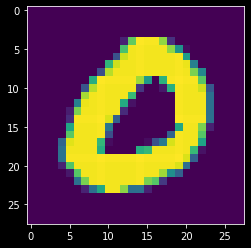

Label: 0
Random Test Example: 


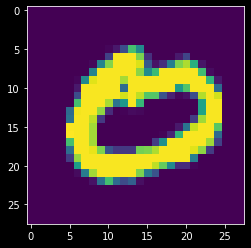

Label: 0


In [ ]:
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = tf.keras.datasets.mnist.load_data()
x_train_mnist = x_train_mnist.reshape((x_train_mnist.shape[0], 28, 28, 1)).astype('float32')
x_test_mnist = x_test_mnist.reshape((x_test_mnist.shape[0], 28, 28, 1)).astype('float32')
x_train_mnist, x_test_mnist = x_train_mnist / 255.0, x_test_mnist / 255.0
input_shape_mnist = x_train_mnist.shape[1:]
classes_mnist = 10
print_dataset_info('MNIST', x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)
show_random_image('MNIST', x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist)

## CIFAR 10

170500096/170498071 [==============================] - 2s 0us/step
CIFAR10 dataset information:
  * Total Train Samples: 50000
  * Total Test Samples:  10000
  * Input Shape:  (32, 32, 3)
  * Output Shape: (1,)
Shapes Detail:
  * x_train:  (50000, 32, 32, 3)
  * y_train:  (50000, 1)
  * x_test:   (10000, 32, 32, 3)
  * y_test:   (10000, 1)
CIFAR10 Classes:
  0- airplane
  1- automobile
  2- bird
  3- cat
  4- deer
  5- dog
  6- frog
  7- horse
  8- ship
  9- truck
Random Train Example: 


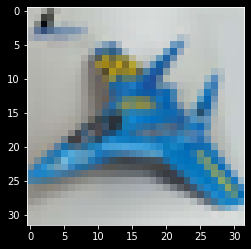

Label: [0]
Random Test Example: 


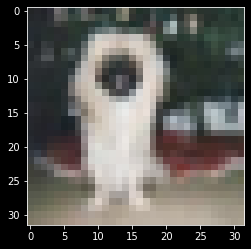

Label: [5]


In [ ]:
(x_train_cifar10, y_train_cifar10), (x_test_cifar10, y_test_cifar10) = tf.keras.datasets.cifar10.load_data()
x_train_cifar10 = x_train_cifar10.astype('float32')
x_test_cifar10 = x_test_cifar10.astype('float32')
x_train_cifar10, x_test_cifar10= x_train_cifar10 / 255, x_test_cifar10 / 255
input_shape_cifar10 = x_train_cifar10.shape[1:]
classes_cifar10 = 10
print_dataset_info('CIFAR10', x_train_cifar10, y_train_cifar10, x_test_cifar10, y_test_cifar10)
print_cifar10_classes()
show_random_image('CIFAR10', x_train_cifar10, y_train_cifar10, x_test_cifar10, y_test_cifar10)


# Achitectures

## VGG16 (CIFAR10)

In [ ]:
def get_vgg16_cifar10(drop_out_rate=0.5, print_summary=True):
    base_model = tf.keras.applications.VGG16(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=input_shape_cifar10,
        pooling=None,
        classes=classes_cifar10,
        classifier_activation=None,
    )
    fc1 = base_model.layers[-3]
    fc2 = base_model.layers[-2]
    predictions = base_model.layers[-1]

    # Create the dropout layers
    dropout1 = tf.keras.layers.Dropout(drop_out_rate)
    dropout2 = tf.keras.layers.Dropout(drop_out_rate)

    # Reconnect the layers
    x = dropout1(fc1.output)
    x = fc2(x)
    x = dropout2(x)
    predictors = predictions(x)

    # Create a new model
    model_vgg16_cifar10 = tf.keras.models.Model(base_model.input, predictors, name='vgg16')

    if print_summary:
        model_vgg16_cifar10.summary()
    return model_vgg16_cifar10

def get_vgg16_mnist(print_summary=False):
    min_shape = (32, 32, 1)
    base_model = tf.keras.applications.VGG16(
        include_top=True,
        weights=None,
        input_tensor=None,
        input_shape=min_shape,
        pooling=None,
        classes=classes_mnist,
        classifier_activation=None,
    )
    resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(min_shape[0], min_shape[1])
    inputs = tf.keras.Input(shape=input_shape_mnist)
    x = resize_layer(inputs)
    outputs = base_model(x)
    model_vgg16_mnist = tf.keras.Model(inputs, outputs, name='vgg16')
    if print_summary:
        model_vgg16_mnist.summary()
    return model_vgg16_mnist

# Optimizers Test

In [ ]:
sparse_categorical_cost = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

## Optimizers Instantiation

### Gravity

In [ ]:
gravity_learning_rate = 0.1
gravity_beta = 0.9
gravity_alpha = 0.01
gravity_opt = Gravity(gravity_learning_rate, alpha=gravity_alpha, beta=gravity_beta)

### Adam

In [ ]:
adam_learning_rate = 0.000095
adam_beta_1 = 0.9
adam_beta_2 = 0.999
adam_epsilon = 1e-07
adam_amsgrad = False

adam_opt = tf.keras.optimizers.Adam(
    learning_rate=adam_learning_rate,
    beta_1=adam_beta_1,
    beta_2=adam_beta_2,
    epsilon=adam_epsilon,
    amsgrad=adam_amsgrad
)

### SGD

In [ ]:
sgd_learning_rate = 0.01
sgd_beta = 0.9

sgd_opt = tf.keras.optimizers.SGD(
    learning_rate=sgd_learning_rate,
    momentum=sgd_beta, 
    nesterov=False,
    name="SGD")

### RMSProp

In [ ]:
rms_opt = tf.keras.optimizers.RMSprop(
    learning_rate=0.01,
    rho=0.9,
    momentum=0.9,
    epsilon=1e-07,
    centered=False,
    name="RMSprop"
    )

## CIFAR10 - VGG16

### Hyper Parameters

In [ ]:
batch_size_cifar10 = 128
epochs_cifar10 = 100

### Gravity Test

In [ ]:
model_vgg16_cifar10_gravity = get_vgg16_cifar10(drop_out_rate=0, print_summary=False)

model_vgg16_cifar10_gravity.compile(optimizer=gravity_opt,
                                    loss=sparse_categorical_cost,
                                    metrics=['accuracy'])
gravity_history = model_vgg16_cifar10_gravity.fit(x_train_cifar10, y_train_cifar10,
                                                  batch_size=batch_size_cifar10,
                                                  epochs=epochs_cifar10,
                                                  validation_data=(x_test_cifar10, y_test_cifar10))

Epoch 1/100
391/391 [==============================] - 29s 74ms/step - loss: 1.9572 - accuracy: 0.2644 - val_loss: 1.5889 - val_accuracy: 0.4107
Epoch 2/100
391/391 [==============================] - 29s 74ms/step - loss: 1.4603 - accuracy: 0.4627 - val_loss: 1.3527 - val_accuracy: 0.5028
Epoch 3/100
391/391 [==============================] - 28s 73ms/step - loss: 1.1660 - accuracy: 0.5801 - val_loss: 1.0944 - val_accuracy: 0.6076
Epoch 4/100
391/391 [==============================] - 29s 73ms/step - loss: 0.9499 - accuracy: 0.6617 - val_loss: 0.9343 - val_accuracy: 0.6677
Epoch 5/100
391/391 [==============================] - 29s 73ms/step - loss: 0.7989 - accuracy: 0.7172 - val_loss: 0.8403 - val_accuracy: 0.7070
Epoch 6/100
391/391 [==============================] - 29s 73ms/step - loss: 0.6566 - accuracy: 0.7719 - val_loss: 0.8033 - val_accuracy: 0.7191
Epoch 7/100
391/391 [==============================] - 29s 73ms/step - loss: 0.5520 - accuracy: 0.8074 - val_loss: 0.7268 - val_ac

In [ ]:
comment = f"""Batch Size: {batch_size_cifar10}
max_step_grad = 1/tf.math.reduce_max(tf.math.abs(grad))
velocity initializer: RandomNormal
beta = beta_hat*t+1/t+2"""
save_run_info(model_vgg16_cifar10_gravity,
              gravity_history,
              gravity_opt,
              'CIFAR10',
              comment=comment)

save_run_info completed


In [ ]:
plot_history(gravity_history)

### Adam

In [ ]:
model_vgg16_cifar10_adam = get_vgg16_cifar10(drop_out_rate=0, print_summary=False)

model_vgg16_cifar10_adam.compile(optimizer=adam_opt,
                                 loss=sparse_categorical_cost_from_logits,
                                 metrics=['accuracy'])
adam_history = model_vgg16_cifar10_adam.fit(x_train_cifar10, y_train_cifar10,
                                                  batch_size=batch_size_cifar10,
                                                  epochs=epochs_cifar10,
                                                  validation_data=(x_test_cifar10, y_test_cifar10))

In [ ]:
comment = f"""Batch Size: {batch_size_cifar10}
max_step_grad = 1/(max_grad-min_grad+self.epsilon)"""
save_run_info(model_vgg16_cifar10_adam,
              adam_history,
              adam_opt,
              'CIFAR10',
              comment=comment)

{'name': 'Adam', 'learning_rate': 0.0001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': 0.0}


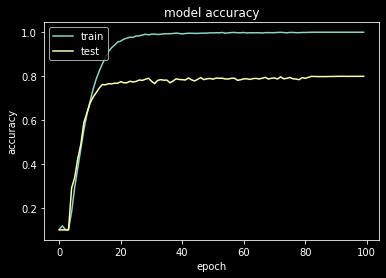

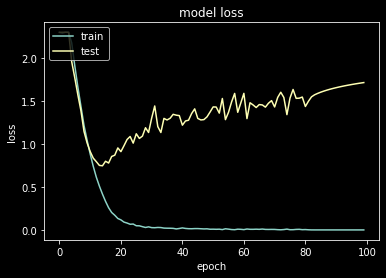

In [ ]:
plot_history(gravity_history)

## MNIST - VGG16

### Hyper Parameters

In [ ]:
batch_size_mnist = 128
epochs_mnist = 100

### Gravity

In [ ]:
model_vgg16_mnist_gravity = get_vgg16_mnist()

model_vgg16_mnist_gravity.compile(optimizer=gravity_opt,
                                  loss=sparse_categorical_cost,
                                  metrics=['accuracy'])
gravity_history = model_vgg16_mnist_gravity.fit(x_train_mnist, y_train_mnist,
                                                batch_size=batch_size_mnist,
                                                epochs=epochs_mnist,
                                                validation_data=(x_test_mnist, y_test_mnist))

In [ ]:
comment = f"""Batch Size: {batch_size_mnist}
max_step_grad = 1/(max_grad-min_grad+self.epsilon)
velocity initializer: RandomNormal
beta = beta_hat*t+1/t+2'"""
save_run_info(model_vgg16_mnist_gravity,
              gravity_history,
              gravity_opt,
              'MNIST',
              comment=comment)

save_run_info completed


In [ ]:
plot_history(gravity_history)

### Adam

In [ ]:
model_vgg16_mnist_adam = get_vgg16_mnist()

model_vgg16_mnist_adam.compile(optimizer=adam_opt,
                               loss=sparse_categorical_cost_from_logits,
                               metrics=['accuracy'])
adam_history = model_vgg16_mnist_adam.fit(x_train_mnist, y_train_mnist,
                                          batch_size=batch_size_mnist,
                                          epochs=epochs_mnist,
                                          validation_data=(x_test_mnist, y_test_mnist))

In [ ]:
comment = f"""Batch Size: {batch_size_mnist}
max_step_grad = 1/(max_grad-min_grad+self.epsilon)"""
save_run_info(model_vgg16_mnist_adam,
              adam_history,
              adam_opt,
              'MNIST',
              comment=comment)

In [ ]:
plot_history(adam_history)